In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

In [2]:
# URL de la página a hacer scraping
url = 'https://www.meff.es/esp/Derivados-Financieros/Ficha/FIEM_MiniIbex_35'

# Realizar la petición HTTP GET a la página
response = requests.get(url)

In [3]:
def obtener_dataframe(response, tipo_tabla):
    """
    Realiza el web scraping y devuelve un dataframe con los datos obtenidos,
    dependiendo si el tipo de tabla es 'opciones' o 'futuros'.
    
    Args:
    - response: La respuesta HTTP obtenida.
    - tipo_tabla: Tipo de la tabla a buscar ('opciones' o 'futuros').
    
    Returns:
    - Un dataframe con los datos de la tabla.
    """
    # Determinar el ID de la tabla y si se necesita manejar el atributo data-tipo
    if tipo_tabla == 'opciones':
        id_tabla = 'tblOpciones'
        es_opcion = True
    elif tipo_tabla == 'futuros':
        id_tabla = 'Contenido_Contenido_tblFuturos'
        es_opcion = False
    else:
        print("Tipo de tabla no soportado.")
        return pd.DataFrame()
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', id=id_tabla)
        all_rows_data = []
        
        if table:
            rows = table.find_all('tr', class_='text-right')
            
            for row in rows:
                cells = row.find_all('td')
                row_data = [cell.text.strip() for cell in cells]
                
                if es_opcion:
                    data_tipo = row.get('data-tipo', 'No especificado')
                    row_data.insert(0, data_tipo)
                    
                all_rows_data.append(row_data)
                
            return pd.DataFrame(all_rows_data)
        else:
            print('No se encontró la tabla con el id especificado.')
            return pd.DataFrame()
    else:
        print('Error al realizar la petición HTTP:', response.status_code)
        return pd.DataFrame()

In [4]:
def tratar_dataframe(df, tipo_tabla):
    """
    Transforma el dataframe según si es de opciones o de futuros.
    
    Args:
    - df: Dataframe a transformar.
    - tipo_tabla: Tipo de la tabla ('opciones' o 'futuros').
    
    Returns:
    - Un dataframe transformado.
    """
    if tipo_tabla == 'opciones':
        # Especificar los nombres de columna para opciones
        df.columns = ['Class', 'Strike', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.','Ant']
        df['Tipo'] = df['Class'].str[:3]
        df['Fecha'] = pd.to_datetime(df['Class'].str[3:], format='%Y%m%d').dt.strftime('%d-%m-%Y')
        df = df.drop(['Class'], axis=1)
        
        # Transformaciones adicionales para opciones
        df['Strike'] = df['Strike'].str.replace('.', '').str.replace(',', '.').astype(float)
        df['Ant'] = pd.to_numeric(df['Ant'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df['Buy_price'] = pd.to_numeric(df['Buy_price'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df['Sell_price'] = pd.to_numeric(df['Sell_price'].str.replace('.', '').str.replace(',', '.'), errors='coerce')

        df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d-%m-%Y')
        
        # Seleccionando solo las columnas deseadas para opciones
        df = df.loc[:, ['Tipo', 'Fecha', 'Strike', 'Buy_price', 'Sell_price', 'Ant']]
        
    elif tipo_tabla == 'futuros':
        # Especificar los nombres de columna para futuros
        df.columns = ['Vencimiento', 'Tipo', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.','Ant']
        
        # Clean up the date string if necessary
        df['Vencimiento'] = df['Vencimiento'].str.replace('.', '')  # Remove periods if present
        df['Vencimiento'] = pd.to_datetime(df['Vencimiento'], format='%d %b %Y', errors='coerce')
        df['Ant'] = pd.to_numeric(df['Ant'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        
        # Seleccionando solo las columnas deseadas para futuros
        df = df.loc[:, ['Vencimiento', 'Ant']]
        
    else:
        print("Tipo de tabla no soportado.")
        return pd.DataFrame()
    
    return df


In [5]:
def calcular_precio_opcion(row, tipo):
    """
    Calcula el precio de la opción, ya sea 'call' o 'put'.
    
    Args:
    - row: La fila del DataFrame.
    - tipo: Tipo de opción ('call' o 'put').
    
    Returns:
    - Precio calculado de la opción.
    """
    if tipo == 'call':
        buy_col = 'Buy_price_call'
        sell_col = 'Sell_price_call'
        ant_col = 'Ant_call'
    elif tipo == 'put':
        buy_col = 'Buy_price_put'
        sell_col = 'Sell_price_put'
        ant_col = 'Ant_put'
    else:
        raise ValueError("Tipo de opción no soportado. Use 'call' o 'put'.")

    # Usar 'Ant_call' o 'Ant_put' si ambas columnas de precios son NA
    if pd.isna(row[buy_col]) and pd.isna(row[sell_col]):
        return row[ant_col]
    elif pd.notna(row[buy_col]) and pd.notna(row[sell_col]):
        return (row[buy_col] + row[sell_col]) / 2
    elif pd.notna(row[buy_col]):
        return row[buy_col]
    elif pd.notna(row[sell_col]):
        return row[sell_col]
    else:
        return None


In [6]:
def datos_opciones(tipo_tabla, response):
    
    df = obtener_dataframe(response, tipo_tabla)
    df = tratar_dataframe(df, tipo_tabla)
    
    df_c = df[df['Tipo'] == 'OCE'].copy()
    df_p = df[df['Tipo'] == 'OPE'].copy()

    df_c.rename(columns={'Buy_price': 'Buy_price_call', 'Sell_price': 'Sell_price_call', 'Ant': 'Ant_call'}, inplace=True)
    df_p.rename(columns={'Buy_price': 'Buy_price_put', 'Sell_price': 'Sell_price_put', 'Ant': 'Ant_put'}, inplace=True)
    
    # Unir los dataframes por 'Strike' y 'Fecha'
    df_final = pd.merge(df_c, df_p, on=['Fecha', 'Strike'], how='outer')

    # Ordenar por 'Fecha' y 'Strike'
    df_final.sort_values(by=['Fecha', 'Strike'], ascending=[True, True], inplace=True)
        
    # Establecer 'Fecha' como índice
    df_final.set_index('Fecha', inplace=True)

    # Calcular la columna 'T' en el DataFrame
    df_final['T'] = (df_final.index - pd.Timestamp(datetime.now().date())).days / 365.25

    df_final = df_final[['Strike', 'Buy_price_call', 'Sell_price_call', 'Ant_call', 'Buy_price_put', 'Sell_price_put', 'Ant_put', 'T']]

    # Aplicar la función para crear las columnas 'Precio_call' y 'Precio_put'
    df_final['Precio_call'] = df_final.apply(lambda row: calcular_precio_opcion(row, 'call'), axis=1)
    df_final['Precio_put'] = df_final.apply(lambda row: calcular_precio_opcion(row, 'put'), axis=1)

    return df_final


In [7]:
def datos_futuros(tipo_tabla, response):
    df = obtener_dataframe(response, 'futuros')
    df = tratar_dataframe(df, 'futuros')

    return df


In [8]:
# Opciones
df_opciones = datos_opciones('opciones', response)

In [9]:
df_opciones

,Strike,Buy_price_call,Sell_price_call,Ant_call,Buy_price_put,Sell_price_put,Ant_put,T,Precio_call,Precio_put
Fecha,,,,,,,,,,
2024-05-03,10600.0,NaN,NaN,509.0,NaN,NaN,NaN,0.008214,509.0,NaN
2024-05-03,10650.0,NaN,NaN,NaN,NaN,NaN,1.0,0.008214,NaN,1.0
2024-05-03,10700.0,NaN,NaN,410.0,NaN,NaN,NaN,0.008214,410.0,NaN
2024-05-03,10750.0,NaN,NaN,NaN,NaN,NaN,3.0,0.008214,NaN,3.0
2024-05-03,10800.0,NaN,NaN,NaN,5.0,NaN,5.0,0.008214,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-20,11400.0,NaN,NaN,398.0,NaN,NaN,NaN,0.640657,398.0,NaN
2024-12-20,11500.0,NaN,NaN,357.0,NaN,NaN,NaN,0.640657,357.0,NaN
2025-03-21,10600.0,NaN,NaN,NaN,NaN,NaN,411.0,0.889802,NaN,411.0


In [10]:
# Opciones
df_futuros = datos_futuros('futuros', response)

In [11]:
df_futuros

,Vencimiento,Ant
0,2024-05-17,11123.7
1,2024-06-21,11142.0
2,2024-07-19,11073.0


In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime

# URL de la página a hacer scraping
url = 'https://www.meff.es/esp/Derivados-Financieros/Ficha/FIEM_MiniIbex_35'

# Realizar la petición HTTP GET a la página
response = requests.get(url)

# Crear un dataframe vacío en caso de error en la petición
df_opciones = pd.DataFrame()
df_futuros = pd.DataFrame()

# Comprobar si la petición fue exitosa
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Scraping de opciones
    table_opciones = soup.find('table', id='tblOpciones')
    all_rows_data = []
    if table_opciones:
        rows = table_opciones.find_all('tr', class_='text-right')
        for row in rows:
            cells = row.find_all('td')
            row_data = [cell.text.strip() for cell in cells]
            data_tipo = row.get('data-tipo', 'No especificado')
            row_data.insert(0, data_tipo)
            all_rows_data.append(row_data)
        
        # Definir los nombres de las columnas
        titulo_columna = ['Class', 'Strike', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.', 'Ant']
        df_opciones = pd.DataFrame(all_rows_data, columns=titulo_columna)
        
        # Limpiar y organizar las columnas
        df_opciones['Tipo'] = df_opciones['Class'].str[:3]
        df_opciones['Fecha'] = pd.to_datetime(df_opciones['Class'].str[3:], format='%Y%m%d').dt.strftime('%d-%m-%Y')
        df_opciones = df_opciones.drop(['Class'], axis=1)
        column_order = ['Tipo', 'Fecha'] + [col for col in df_opciones.columns if col not in ['Tipo', 'Fecha']]
        df_opciones = df_opciones.reindex(columns=column_order)
        
        # Convertir el formato de 'Strike' y precios a numérico
        df_opciones['Strike'] = pd.to_numeric(df_opciones['Strike'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df_opciones['Buy_price'] = pd.to_numeric(df_opciones['Buy_price'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df_opciones['Sell_price'] = pd.to_numeric(df_opciones['Sell_price'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        
        # Convertir la columna 'Fecha' a tipo datetime
        df_opciones['Fecha'] = pd.to_datetime(df_opciones['Fecha'], format='%d-%m-%Y')
        
        # Separar los dataframes de Calls y Puts
        calls = df_opciones[df_opciones['Tipo'] == 'OCE'][['Fecha', 'Strike', 'Buy_price', 'Sell_price']]
        puts = df_opciones[df_opciones['Tipo'] == 'OPE'][['Fecha', 'Strike', 'Buy_price', 'Sell_price']]
        
        # Renombrar columnas para Calls y Puts
        calls.rename(columns={'Buy_price': 'Call_buy_price', 'Sell_price': 'Call_sell_price'}, inplace=True)
        puts.rename(columns={'Buy_price': 'Put_buy_price', 'Sell_price': 'Put_sell_price'}, inplace=True)
        
        # Unir los dataframes por 'Strike' y 'Fecha'
        combined_df = pd.merge(calls, puts, on=['Fecha', 'Strike'], how='outer')
        
        # Ordenar por 'Fecha' y 'Strike'
        combined_df.sort_values(by=['Fecha', 'Strike'], ascending=[True, True], inplace=True)
        
        # Establecer 'Fecha' como índice
        combined_df.set_index('Fecha', inplace=True)
        
        # Calcular la columna 'T' en el DataFrame combined_df
        combined_df['T'] = (combined_df.index - pd.Timestamp(datetime.now().date())).days / 365.25
        
        # Seleccionar las columnas deseadas
        combined_df = combined_df[['Strike', 'Call_buy_price', 'Call_sell_price', 'Put_buy_price', 'Put_sell_price', 'T']]
        
        # Exportar el DataFrame limpio y organizado
        combined_df.to_csv('opciones_mini_ibex_35.csv', sep=';', decimal=',', index=True)
        
        print("Dataframe de Opciones:")
        print(combined_df.head())

    # Scraping de futuros
    tabla_futuros = soup.find('table', {'id': 'Contenido_Contenido_tblFuturos'})
    datos_tabla = []
    if tabla_futuros:
        for fila in tabla_futuros.find_all('tr')[2:]:
            celdas = fila.find_all('td')
            fila_datos = [celda.get_text(strip=True) for celda in celdas]
            datos_tabla.append(fila_datos)

        columnas = ['Vencimiento', 'Tipo', 'Compra_Ord', 'Compra_Vol', 'Compra_Precio', 'Venta_Precio', 'Venta_Vol', 'Venta_Ord', 'Ult', 'Vol', 'Aper', 'Max', 'Min', 'Ant']
        df_futuros = pd.DataFrame(datos_tabla, columns=columnas)

        # Limpieza y conversión de tipos de datos como hemos hecho previamente
        df_futuros['Compra_Precio'] = pd.to_numeric(df_futuros['Compra_Precio'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df_futuros['Venta_Precio'] = pd.to_numeric(df_futuros['Venta_Precio'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df_futuros['Vencimiento'] = pd.to_datetime(df_futuros['Vencimiento'], format='%d %b %Y', errors='coerce')

        # Guardar el DataFrame de Futuros en un archivo CSV delimitado por ; y decimales con ,
        df_futuros.to_csv('futuros_mini_ibex_35.csv', sep=';', decimal=',', index=False)

        print("\nDataframe de Futuros:")
        print(df_futuros.head())


Dataframe de Opciones:
             Strike  Call_buy_price  Call_sell_price  Put_buy_price  \
Fecha                                                                 
2024-05-03  10600.0             NaN              NaN            NaN   
2024-05-03  10650.0             NaN              NaN            NaN   
2024-05-03  10700.0             NaN              NaN            NaN   
2024-05-03  10750.0             NaN              NaN            NaN   
2024-05-03  10800.0             NaN              NaN            5.0   

            Put_sell_price         T  
Fecha                                 
2024-05-03             NaN  0.008214  
2024-05-03             NaN  0.008214  
2024-05-03             NaN  0.008214  
2024-05-03             NaN  0.008214  
2024-05-03             NaN  0.008214  

Dataframe de Futuros:
  Vencimiento    Tipo Compra_Ord Compra_Vol  Compra_Precio  Venta_Precio  \
0         NaT  Difer.          4         13        10855.0       10860.0   
1         NaT  Difer.          

**Cálculo volatilidades implícitas**

In [13]:
# Función para calcular el precio de una opción call europea usando Black-Scholes
def black_scholes_call(S, K, T, r, sigma):
    if T <= 0:  # No se puede calcular precio de una opción con tiempo hasta vencimiento negativo o cero
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    if T <= 0:  # No se puede calcular precio de una opción con tiempo hasta vencimiento negativo o cero
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Función para extraer la volatilidad implícita
def implied_volatility(option_price, S, K, T, r, option_type):
    """Calcula la volatilidad implícita de una opción dada su precio de mercado.
    option_price : Precio de mercado de la opción
    S : Precio del activo subyacente
    K : Precio de ejercicio
    T : Tiempo hasta el vencimiento
    r : Tasa de interés libre de riesgo
    option_type : Tipo de opción ('call' o 'put')
    """
    if option_price <= 0 or T <= 0:
        return 0
    # Función objetivo para encontrar la volatilidad implícita
    def objective(sigma):
        if option_type == 'call':
            return black_scholes_call(S, K, T, r, sigma) - option_price
        else:
            return black_scholes_put(S, K, T, r, sigma) - option_price
    # Resolver usando Brent's method
    try:
        result = brentq(objective, 1e-6, 4)
        return result
    except ValueError:
        return np.nan  



In [14]:
price_sub = df_futuros.loc[0, 'Ant']
rfr = 0.01

In [71]:
try:
    # Leer el archivo, especificando el separador y el carácter decimal
    df_opciones = pd.read_csv('opciones_mini_ibex_35.csv', on_bad_lines='skip')
    
    # Convertir la columna 'Fecha' a datetime
    df_opciones['Fecha'] = pd.to_datetime(df_opciones['Fecha'])
    
    # Establecer la columna 'Fecha' como el índice del DataFrame
    df_opciones.set_index('Fecha', inplace=True)
    
    # Convertir todas las columnas numéricas asegurándose de que son tratadas como float
    cols_numericas = df_opciones.columns.drop('Fecha', errors='ignore')  # Excluir la columna de fecha, ahora índice
    df_opciones[cols_numericas] = df_opciones[cols_numericas].apply(pd.to_numeric, errors='coerce')
    

except Exception as e:
    pass

In [75]:
# Calcular la volatilidad implícita para cada opción en combined_df
df_opciones['Vol_call'] = df_opciones.apply(lambda row: implied_volatility(row['Precio_call'], price_sub, row['Strike'], row['T'], rfr, 'call'), axis=1)
df_opciones['Vol_put'] = df_opciones.apply(lambda row: implied_volatility(row['Precio_put'], price_sub, row['Strike'], row['T'], rfr, 'put'), axis=1)

In [74]:
df_opciones.index.unique()

DatetimeIndex(['2024-04-26', '2024-05-03', '2024-05-10', '2024-05-17',
               '2024-06-21', '2024-07-19', '2024-09-20', '2024-12-20',
               '2025-03-21', '2025-06-20', '2025-12-19'],
              dtype='datetime64[ns]', name='Fecha', freq=None)

In [76]:
volatilidades = df_opciones.loc[:, ['Strike', 'Vol_call', 'Vol_put']]
volatilidades

,Strike,Vol_call,Vol_put
Fecha,,,
2024-04-26,9000.0,2.619809,1.220337
2024-04-26,9100.0,2.516442,1.159699
2024-04-26,9200.0,2.413372,1.099409
2024-04-26,9300.0,2.310520,1.039433
2024-04-26,9400.0,2.207801,0.979735
...,...,...,...
2025-06-20,13300.0,0.140974,NaN
2025-06-20,13400.0,0.140570,NaN
2025-06-20,13500.0,0.140254,NaN


In [68]:
try:
    # Asumiendo que df_opciones ya está correctamente procesado y configurado
    # Guardar el DataFrame en un archivo CSV, incluyendo el índice
    volatilidades.to_csv('volatilidades.csv', index=True)
    print("El archivo ha sido guardado exitosamente.")
except Exception as e:
    print("Error al guardar el archivo:", e)

El archivo ha sido guardado exitosamente.


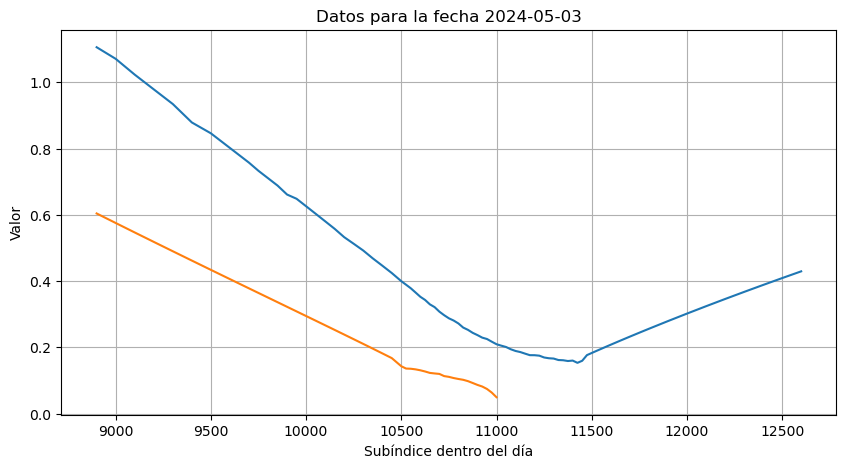

In [77]:
# Paso 1: Definir la fecha que quieres graficar
fecha_deseada = '2024-05-03'  # Cambia esta fecha según tus necesidades

# Paso 2: Filtrar los datos para la fecha seleccionada
datos_filtrados_call = volatilidades.loc[fecha_deseada]
datos_filtrados_put = volatilidades.loc[fecha_deseada]

# Paso 3: Graficar los datos
plt.figure(figsize=(10, 5))  # Configura el tamaño del gráfico como desees
plt.plot(datos_filtrados_call['Strike'], datos_filtrados_call['Vol_call'], linestyle='-')
plt.plot(datos_filtrados_put['Strike'], datos_filtrados_put['Vol_put'], linestyle='-')
# Asegúrate de reemplazar 'tu_columna_de_datos' con el nombre de la columna real que deseas graficar

plt.title(f'Datos para la fecha {fecha_deseada}')
plt.xlabel('Subíndice dentro del día')  # Ajusta según la estructura de tu DataFrame
plt.ylabel('Valor')  # Ajusta este label según los datos que estás graficando
plt.grid(True)
plt.show()

**Dash**

In [103]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Simulación de datos, reemplázalos con tus datos reales
# Generamos algunas fechas y datos ficticios
np.random.seed(0)
fechas = pd.date_range('2024-01-01', periods=100)
strikes = np.linspace(100, 200, 100)
vol_calls = np.random.rand(100)
vol_puts = np.random.rand(100)

volatilidades = pd.DataFrame({
    'Fecha': np.tile(fechas, 100),
    'Strike': np.repeat(strikes, 100),
    'Vol_call': np.tile(vol_calls, 100),
    'Vol_put': np.tile(vol_puts, 100)
})
volatilidades.set_index('Fecha', inplace=True)

# Inicia la aplicación de Dash
app = dash.Dash(__name__)

# Diseño de la aplicación
app.layout = html.Div([
    dcc.DatePickerSingle(
        id='fecha-picker',
        min_date_allowed=volatilidades.index.min(),
        max_date_allowed=volatilidades.index.max(),
        date=str(volatilidades.index.max())
    ),
    dcc.Graph(id='volatility-graph')
])

# Callback para actualizar el gráfico
@app.callback(
    Output('volatility-graph', 'figure'),
    [Input('fecha-picker', 'date')]
)
def update_graph(selected_date):
    if selected_date is not None:
        filtered_data_call = volatilidades.loc[selected_date]
        filtered_data_put = volatilidades.loc[selected_date]

        return {
            'data': [
                go.Scatter(x=filtered_data_call['Strike'], y=filtered_data_call['Vol_call'], mode='lines', name='Vol Call'),
                go.Scatter(x=filtered_data_put['Strike'], y=filtered_data_put['Vol_put'], mode='lines', name='Vol Put')
            ],
            'layout': go.Layout(
                title=f'Datos para la fecha {selected_date}',
                xaxis={'title': 'Strike'},
                yaxis={'title': 'Volatilidad'},
                plot_bgcolor='white'
            )
        }

In [104]:
# Ejecuta la aplicación
if __name__ == '__main__':
    app.run_server(debug=True)